In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

In [2]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:.4f}'.format)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

# Data loading and exploration

In [3]:
# time series data with 10 sec interval

df = pd.read_parquet('data/bms_soc_data.parquet')

In [4]:
df.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,bms_max_cell_voltage
time,,,,,,,,,,,,,,,
2023-11-07 12:20:00+00:00,100.0000,509.9220,3.4113,0.0262,-24.1460,24.1000,3.4018,3.4168,3.4110,3.4240,3.4138,3.3978,3.4136,3.4114,3.4240
2023-11-07 12:20:10+00:00,100.0000,509.8500,3.4083,0.0252,-10.2840,24.1000,3.3998,3.4132,3.4082,3.4214,3.4104,3.3962,3.4096,3.4072,3.4214
2023-11-07 12:20:20+00:00,100.0000,509.8200,3.4049,0.0246,-11.9420,24.1000,3.3968,3.4096,3.4042,3.4174,3.4068,3.3928,3.4066,3.4046,3.4174
2023-11-07 12:20:30+00:00,100.0000,509.8100,3.4148,0.0256,17.6280,24.0800,3.4064,3.4202,3.4148,3.4292,3.4154,3.4036,3.4164,3.4124,3.4292
2023-11-07 12:20:40+00:00,100.0000,510.0000,3.4208,0.0264,19.0480,24.1000,3.4112,3.4264,3.4200,3.4358,3.4220,3.4094,3.4224,3.4190,3.4358


In [5]:
# Attempt to calculate SOC as accurate as we can
# the internal current sensor is not accurate and has different error on charge and discharge
# we need to detect voltage peaks and reset SOC to 100%  
# it's a moment when we have average voltage at 3.44 and then drop below 3.37 (reset condition)

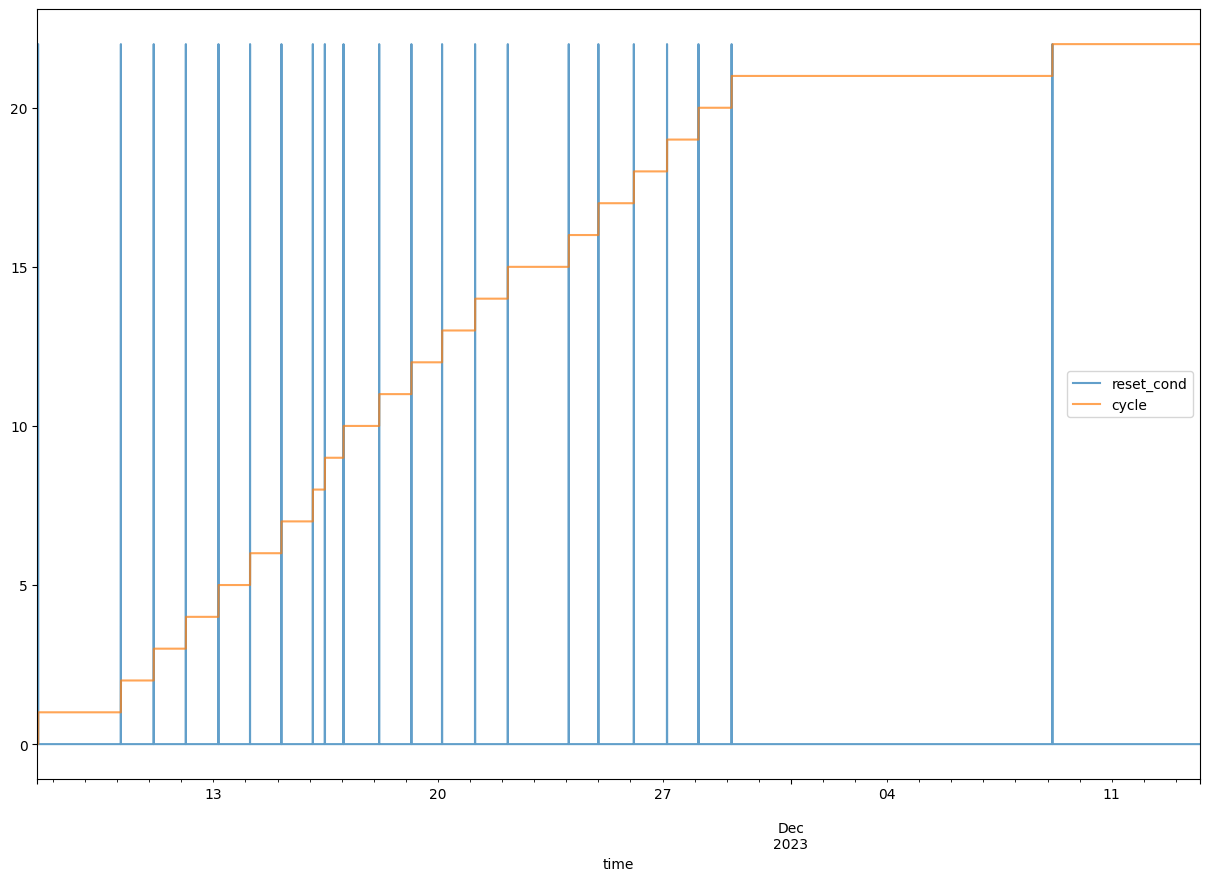

In [6]:
#ax1 = df.plot.line( y=['bms_average_cell_voltage'], alpha=0.8, figsize = (15, 10) )

df2 = df.copy()

df2['reset_cond'] = df2.bms_average_cell_voltage.rolling(5).mean() > 3.44
df2['reset_cond2'] = df2.bms_average_cell_voltage.rolling(5).mean() < 3.37
df2['reset_cond'] = df2.reset_cond.shift(100) & df2.reset_cond2
df2['reset_cond2'] = (df2.reset_cond.shift(1) == 1) & (df2.reset_cond == 0) # falling edge
df2['cycle'] = df2.reset_cond2.cumsum().astype('int32')
df2['cycle_row'] = df2.groupby(['cycle']).cumcount()

df2['reset_cond'] = df2['reset_cond'].astype('float16') * df2.cycle.max()
#df2['cycle'] = df2['cycle'].astype('float16')
#fig = px.line(df2[:10000], y=['bms_average_cell_voltage', 'reset_cond'], width=1200, height=600)
#fig.show()
ax1 = df2.plot.line( y=['reset_cond','cycle'], alpha=0.7, figsize = (15, 10) )

In [7]:
# drop non complete cycles
max_cycle = df2.cycle.max()
df2_full_cycles = df2.loc[ (df2.cycle > 0) & (df2.cycle < max_cycle)]
df2 = df2.loc[ df2.cycle > 0 ]

In [8]:
# coulonometer error per cycle (overshoot/undershoot)
df2_full_cycles.groupby(['cycle'])['bms_current'].sum()/360  # 3600 / 10 sec

cycle
1    100.3926
2     40.1183
3     44.9095
4     43.2768
5     44.5536
6     42.3141
7     39.5786
8      9.3848
9     28.5217
10    45.7310
11    44.1783
12    43.2185
13    44.5119
14    45.2486
15    85.3100
16    37.1988
17    43.7803
18    44.3628
19    41.9267
20    44.9050
21   390.8566
Name: bms_current, dtype: float64

In [9]:
# Difference between energy in and energy out (A*h) for one cycle on average 
avg_shift_k = (df2_full_cycles.groupby(['cycle'])['bms_current'].sum()/360).mean()
avg_shift_k

62.10850174162258

In [10]:
# coulombic efficiency of a lfp battery is about 0.99
coulombic_efficiency = 0.99

In [11]:
corr = df2.groupby(['cycle'])['bms_current'].agg([('discharge' , lambda x : x[x < 0].sum()) , ('charge' , lambda x : x[x > 0].sum())]) / 360
corr['k'] = -corr.charge / corr.discharge
corr.k.mean()

1.0880943793104676

In [12]:
corr

,discharge,charge,k
cycle,,,
1,-988.1548,1088.5474,1.1016
2,-411.1175,451.2359,1.0976
3,-455.0306,499.9401,1.0987
4,-447.3192,490.5960,1.0967
5,-454.4380,498.9916,1.0980
6,-432.6957,475.0099,1.0978
7,-403.5707,443.1493,1.0981
8,-93.8042,103.1889,1.1000
9,-276.7099,305.2316,1.1031


In [13]:
discharge_sum = df2_full_cycles[df2_full_cycles.bms_current < 0].bms_current.sum()
charge_sum = df2_full_cycles[df2_full_cycles.bms_current > 0].bms_current.sum()
#corr_k = charge_sum * coulombic_efficiency / -discharge_sum
corr_k = charge_sum / -discharge_sum
corr_k

1.0984709568262379

In [14]:
def correct(x):
    if x < 0:
        return x * corr_k
    return x

df2.loc[:,'bms_current_corrected'] = df2['bms_current'].apply(correct).copy()
df2_full_cycles.loc[:,'bms_current_corrected'] = df2_full_cycles['bms_current'].apply(correct).copy()
#df2['bms_current_corrected'] = df2['bms_current'].apply(correct)

In [15]:
# calculated SOC
max_capacity = 510.0
df2.loc[:,'calculated_soc'] = (( ( df2.groupby(['cycle'])['bms_current_corrected'].cumsum()/360) + max_capacity) / max_capacity) * 100.0
df2.loc[:,'calculated_soc'] = df2.calculated_soc.clip(0, 100.0)

df2_full_cycles.loc[:,'calculated_soc'] = (( ( df2_full_cycles.groupby(['cycle'])['bms_current_corrected'].cumsum()/360) + max_capacity) / max_capacity) * 100.0
df2_full_cycles.loc[:,'calculated_soc'] = df2_full_cycles.calculated_soc.clip(0, 100.0)

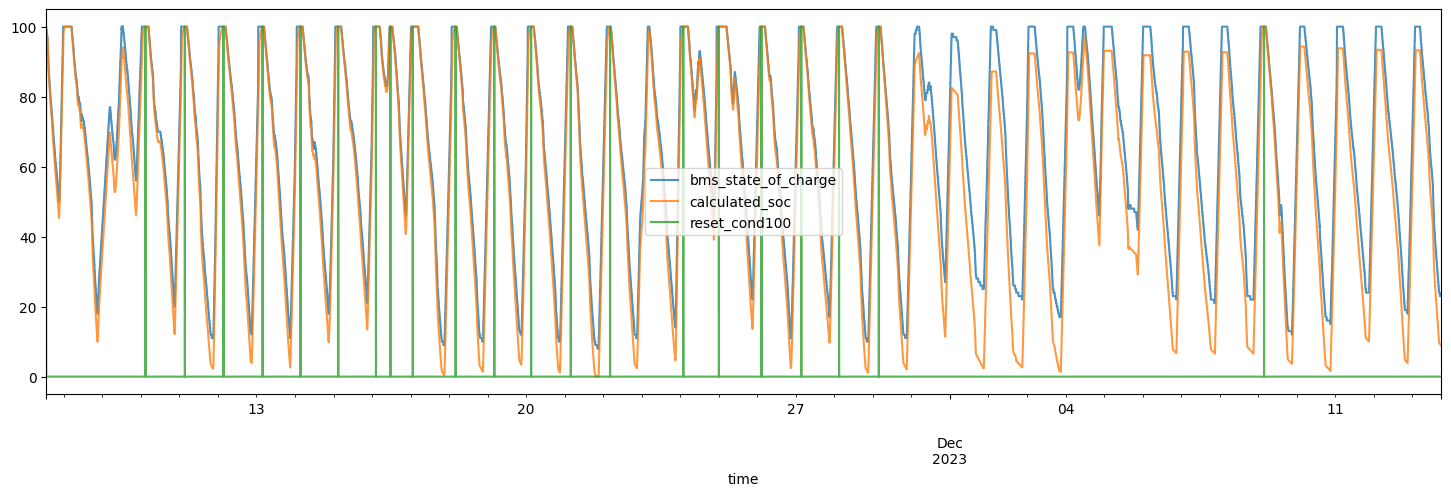

In [16]:
df2.loc[:,'reset_cond100'] = df2['reset_cond2'].astype('float16') * 100
ax1 = df2.plot.line( y=['bms_state_of_charge', 'calculated_soc', 'reset_cond100'], alpha=0.8, figsize = (18, 5) )
#ax1.axhline(0, c='r')

In [17]:
df2 = df2.drop(columns=['reset_cond', 'reset_cond2'])
df2_full_cycles = df2_full_cycles.drop(columns=['reset_cond', 'reset_cond2'])

In [18]:
# Select only trusted data (24h after SOC reset)
#cycles_row_max = 24 * 60 * 60 / 10 
#df2 = df2.loc[df2.cycle_row < cycles_row_max]

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 312829 entries, 2023-11-07 12:58:10+00:00 to 2023-12-13 17:56:10+00:00
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bms_state_of_charge       312814 non-null  float64
 1   bms_capacity_remaining    312814 non-null  float64
 2   bms_average_cell_voltage  312814 non-null  float64
 3   bms_delta_cell_voltage    312814 non-null  float64
 4   bms_current               312814 non-null  float64
 5   bms_temperature_2         312814 non-null  float64
 6   bms_cell_voltage_1        312814 non-null  float64
 7   bms_cell_voltage_2        312814 non-null  float64
 8   bms_cell_voltage_3        312814 non-null  float64
 9   bms_cell_voltage_4        312814 non-null  float64
 10  bms_cell_voltage_5        312814 non-null  float64
 11  bms_cell_voltage_6        312814 non-null  float64
 12  bms_cell_voltage_7        312814 non-null  float64
 13

In [20]:
# Is there something special about cell voltage difference ?

df2['cd'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_4)

df2['cd2'] = abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_1) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_2) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_3) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_4) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_5) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_6) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_7) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_8) 
df2['cd3'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_7) # * (df2.bms_cell_voltage_7 - df2.bms_cell_voltage_4) * 10
#df['cd3'] = 
#df['cd'] = df.current / df.cd 
#df2 = df.copy()
#df2 = df2.resample('1min').mean()

In [21]:
def cord(r):
    cl = [ r['bms_cell_voltage_1'], r['bms_cell_voltage_2'], r['bms_cell_voltage_3'], \
          r['bms_cell_voltage_4'], r['bms_cell_voltage_5'], r['bms_cell_voltage_6'], \
          r['bms_cell_voltage_7'], r['bms_cell_voltage_8'],]
    sorted_cl = [i[0] for i in sorted(enumerate(cl), key=lambda x:x[1])]
    return int(''.join(str(item) for item in sorted_cl))

df2['cord'] = df2.apply(cord, axis=1)
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,bms_max_cell_voltage,cycle,cycle_row,bms_current_corrected,calculated_soc,reset_cond100,cd,cd2,cd3,cord
time,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,3.3306,1,0,-12.0348,99.9934,100.0000,0.0010,0.0103,0.0004,53160472
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,3.3306,1,1,-12.3951,99.9867,0.0000,0.0007,0.0100,0.0001,51306742
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,3.3300,1,2,-10.1323,99.9812,0.0000,0.0008,0.0098,0.0002,51367042
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,3.3304,1,3,-11.1231,99.9751,0.0000,0.0002,0.0086,0.0006,51630742
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,3.3284,1,4,-6.9094,99.9714,0.0000,0.0013,0.0092,-0.0001,53160472


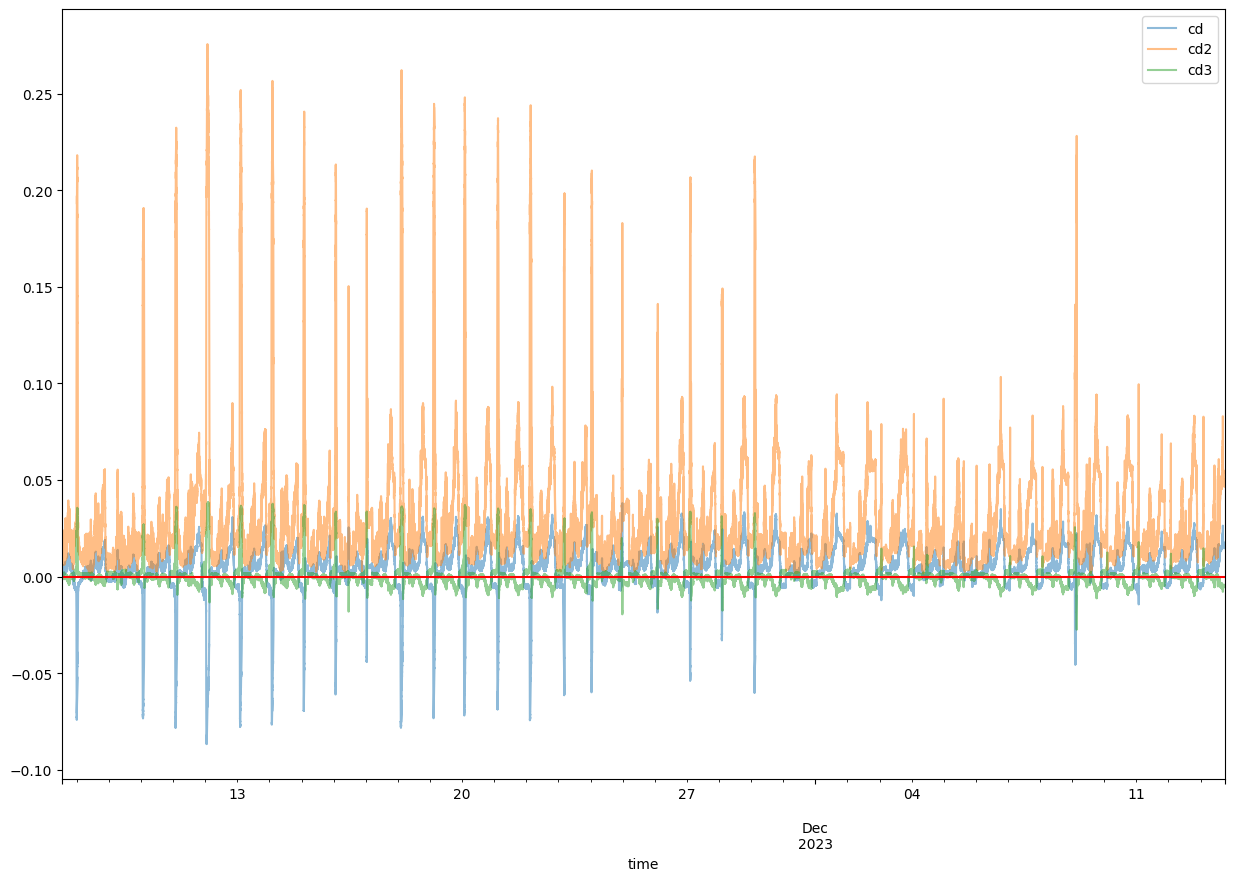

In [22]:
ax1 = df2.plot.line( y=['cd', 'cd2', 'cd3'], alpha=0.5, figsize = (15, 10) )
ax1.axhline(0, c='r')

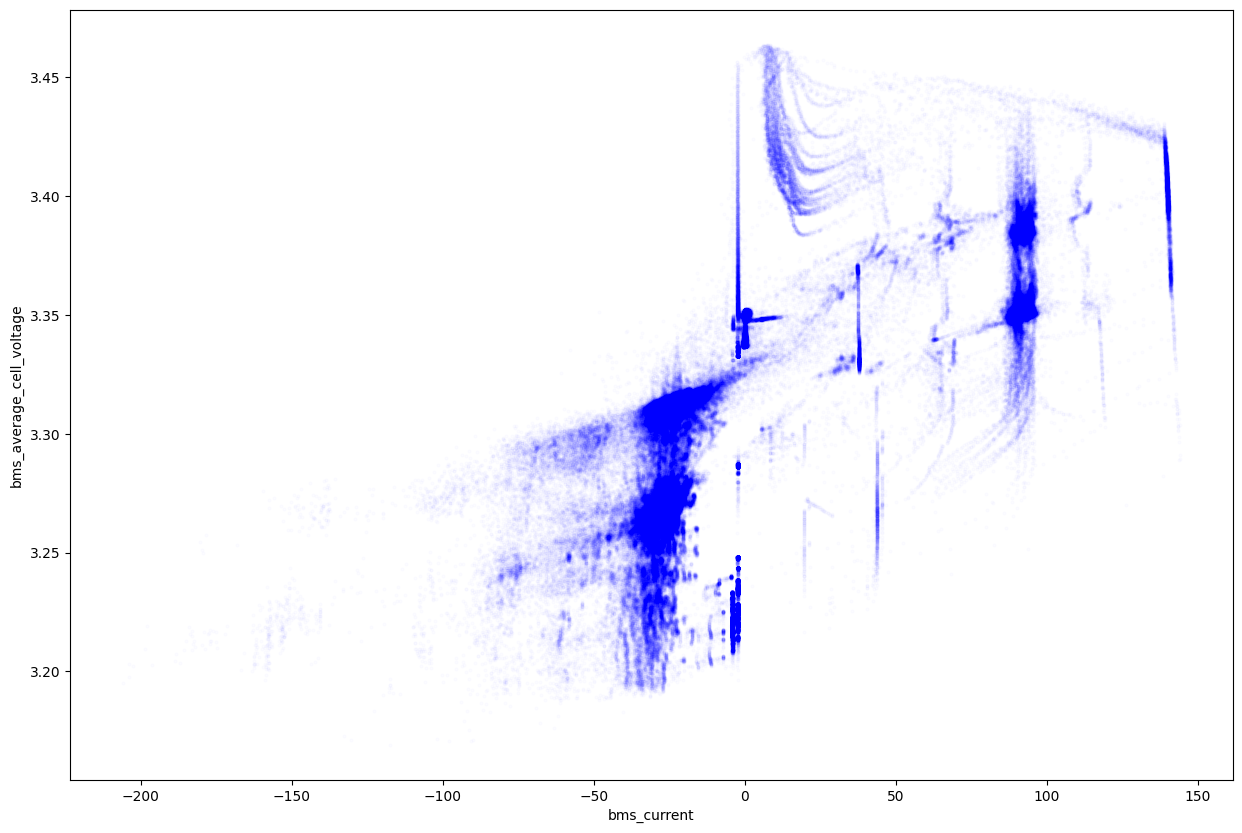

In [23]:
# relationship between current and battery cell voltages

ax1 = df2.plot.scatter(x='bms_current',
                      y='bms_average_cell_voltage',
                      c='Blue', alpha=0.01, marker='.', figsize = (15, 10) )

In [24]:
df3 = df.copy()
df3['volt_diff'] = df2.bms_average_cell_voltage.diff()
df3['current_diff'] = df2.bms_current.diff()

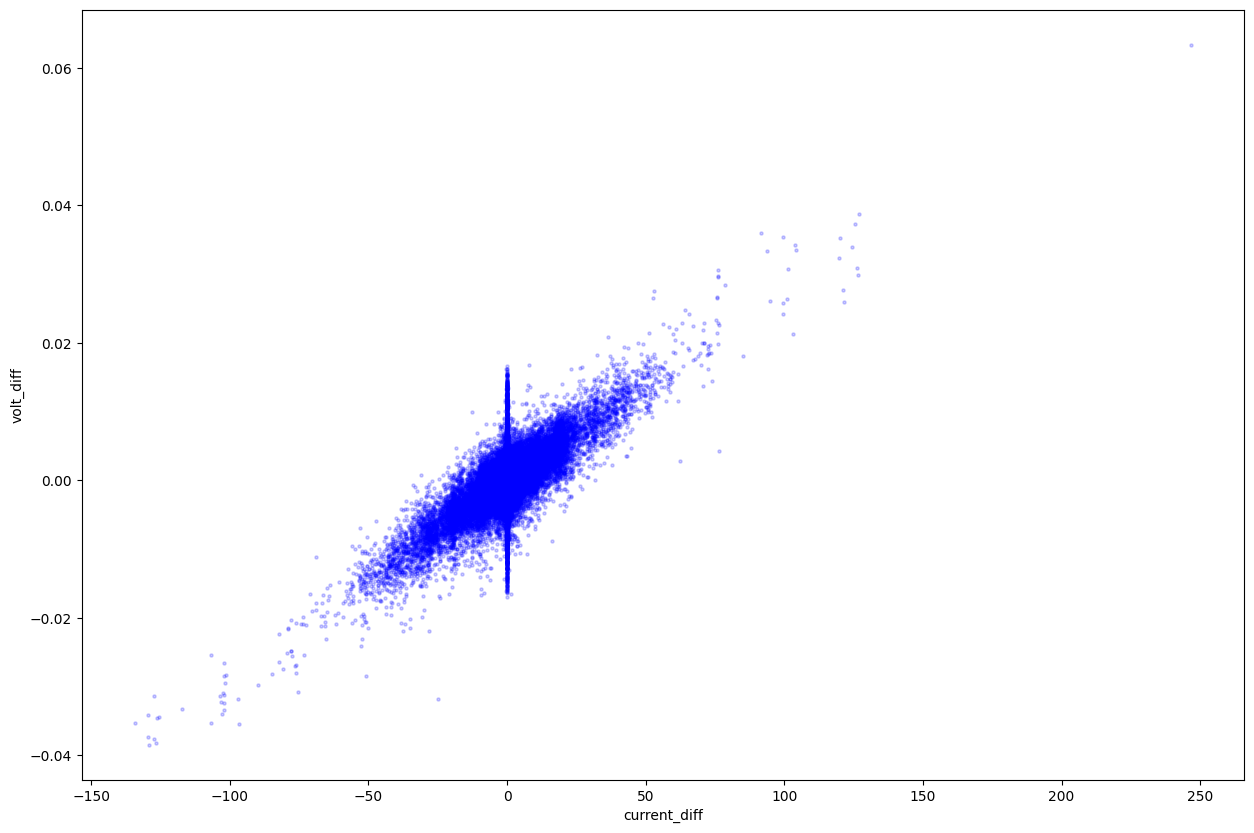

In [25]:
ax1 = df3.plot.scatter(x='current_diff',
                      y='volt_diff',
                      c='Blue', alpha=0.2, marker='.', figsize = (15, 10) )

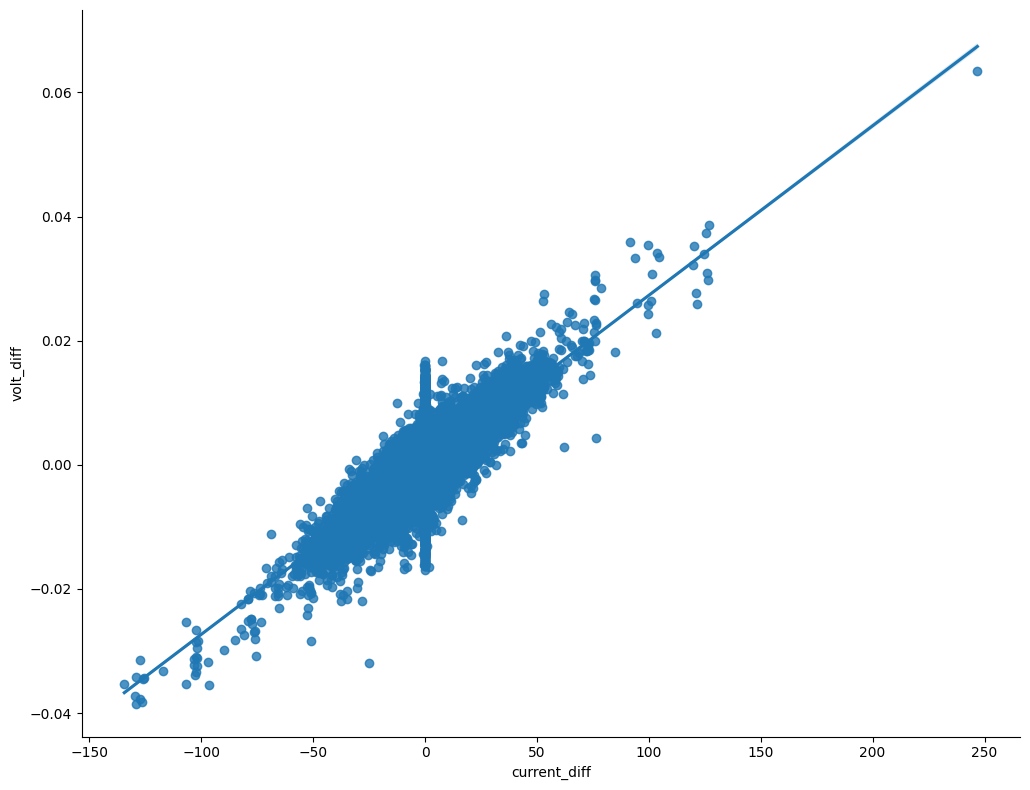

In [26]:
import seaborn as sns
#from matplotlib import pyplot as plt
#plt.figure(figsize=(15,8))
sns.lmplot(x='current_diff',y='volt_diff',data=df3,fit_reg=True, height=8, aspect=1.3) 

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [28]:
df3 = df3.dropna()
X = df3.current_diff.values.reshape(-1,1)
y = df3.volt_diff.values.reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.4853268038948062

In [29]:
reg.coef_[0][0]

0.00027310323177447837

In [30]:
reg.intercept_[0]

-2.789653855329117e-07

In [31]:
# what if will take average deviation for a 5-10 min of voltage and current ?

In [32]:
df['cv_corr'] = df.bms_average_cell_voltage - df.bms_current * reg.coef_[0][0] * 2 + reg.intercept_[0]
df2['cv_corr'] = df2.bms_average_cell_voltage - df2.bms_current * reg.coef_[0][0] * 1 + reg.intercept_[0]

In [33]:
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,bms_max_cell_voltage,cycle,cycle_row,bms_current_corrected,calculated_soc,reset_cond100,cd,cd2,cd3,cord,cv_corr
time,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,3.3306,1,0,-12.0348,99.9934,100.0000,0.0010,0.0103,0.0004,53160472,3.3310
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,3.3306,1,1,-12.3951,99.9867,0.0000,0.0007,0.0100,0.0001,51306742,3.3306
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,3.3300,1,2,-10.1323,99.9812,0.0000,0.0008,0.0098,0.0002,51367042,3.3297
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,3.3304,1,3,-11.1231,99.9751,0.0000,0.0002,0.0086,0.0006,51630742,3.3306
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,3.3284,1,4,-6.9094,99.9714,0.0000,0.0013,0.0092,-0.0001,53160472,3.3278


In [34]:
#fig = px.line(df2, y=["cv_corr","bms_average_cell_voltage"], width=1200, height=600)
#fig.show()

# Modeling

In [35]:
dc = df2.copy()
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,bms_max_cell_voltage,cycle,cycle_row,bms_current_corrected,calculated_soc,reset_cond100,cd,cd2,cd3,cord,cv_corr
time,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,3.3306,1,0,-12.0348,99.9934,100.0000,0.0010,0.0103,0.0004,53160472,3.3310
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,3.3306,1,1,-12.3951,99.9867,0.0000,0.0007,0.0100,0.0001,51306742,3.3306
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,3.3300,1,2,-10.1323,99.9812,0.0000,0.0008,0.0098,0.0002,51367042,3.3297
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,3.3304,1,3,-11.1231,99.9751,0.0000,0.0002,0.0086,0.0006,51630742,3.3306
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,3.3284,1,4,-6.9094,99.9714,0.0000,0.0013,0.0092,-0.0001,53160472,3.3278


In [133]:
df2 = dc.copy()

In [134]:
df2.describe().T

/home/axel/simple-twitter-listener/venv/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,count,mean,std,min,25%,50%,75%,max
bms_state_of_charge,312814.0000,64.9417,27.6326,8.0000,42.0000,68.0000,90.0000,100.0000
bms_capacity_remaining,312814.0000,331.1442,140.8345,40.5120,216.4300,348.5110,459.7600,510.0000
bms_average_cell_voltage,312814.0000,3.3067,0.0533,3.1693,3.2667,3.3103,3.3466,3.4636
bms_delta_cell_voltage,312814.0000,0.0137,0.0143,0.0010,0.0058,0.0092,0.0162,0.1116
bms_current,312814.0000,1.2037,48.9605,-205.8680,-27.8620,-20.6400,1.1480,143.9880
bms_temperature_2,312814.0000,23.4675,2.5599,17.9000,21.6000,23.1400,24.9800,33.4000
bms_cell_voltage_1,312814.0000,3.3080,0.0521,3.1758,3.2684,3.3116,3.3462,3.4794
bms_cell_voltage_2,312814.0000,3.3053,0.0581,3.1552,3.2656,3.3096,3.3448,3.4768
bms_cell_voltage_3,312814.0000,3.3082,0.0511,3.1770,3.2684,3.3120,3.3480,3.4788
bms_cell_voltage_4,312814.0000,3.3030,0.0626,3.1356,3.2618,3.3070,3.3420,3.4906


In [135]:
df2['soc_d'] = df2.calculated_soc.shift(90)
df2['cur_d'] = df2.bms_current.shift(90)
df2['volt_d'] = df2.bms_average_cell_voltage.shift(90)

In [136]:
df2['v_c'] = df2.bms_average_cell_voltage - df2.bms_current * 0.001

In [137]:
df2['volt_diff'] = df2.bms_average_cell_voltage.diff()

In [138]:
df2['roll_v_10'] = df2.bms_average_cell_voltage.rolling(10).mean()
df2['roll_c_10'] = df2.bms_current.rolling(10).mean()

# interesting observation here
# decision tree model fails to learn a + b = c
# this is natural since it partitioning the data
# the neural network in this case would be able to learn that relationship
# since we have direct solution with the following feature
df2['roll_cs_90'] = df2.bms_current.rolling(90).sum()

#df2['roll_vs_90'] = df2.bms_average_cell_voltage.rolling(90).sum()
df2['roll_v_90'] = df2.bms_average_cell_voltage.rolling(90).mean()
df2['roll_c_90'] = df2.bms_current.rolling(90).mean()
#df2['v_trend'] = df2.roll_v_10 / (df2.roll_v_25 + 1)
df2['temp_roll_90'] = df2.bms_temperature_2.rolling(90).mean()

In [139]:
df2['roll_d_10'] = df2.volt_diff.rolling(10).mean()
df2['roll_d_25'] = df2.volt_diff.rolling(25).mean()
df2['d_trend'] = df2.roll_d_10 / (df2.roll_d_25 + 1 )

In [140]:
#df2['t2_trend'] = df2.bms_temperature_2.rolling(10).mean() / (df2.bms_temperature_2.rolling(25).mean() + 1 )

In [141]:
df2 = df2.dropna()

In [142]:
# Select only trusted data (30h after SOC reset)
cycles_row_max = 30 * 60 * 60 / 10 
df2 = df2.loc[df2.cycle_row < cycles_row_max]

In [143]:
df2.head(10)

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,bms_max_cell_voltage,...,cv_corr,soc_d,cur_d,volt_d,v_c,volt_diff,roll_v_10,roll_c_10,roll_cs_90,roll_v_90,roll_c_90,temp_roll_90,roll_d_10,roll_d_25,d_trend
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 13:13:10+00:00,99.0000,503.3060,3.3145,0.0042,-18.2420,23.8000,3.3158,3.3144,3.3160,3.3128,3.3152,3.3124,3.3136,3.3158,3.3164,...,3.3195,99.9934,-10.9560,3.3280,3.3327,0.0013,3.3131,-23.0148,-1426.3260,3.3193,-15.8481,23.8564,0.0002,0.0002,0.0002
2023-11-07 13:13:20+00:00,99.0000,503.2500,3.3148,0.0044,-17.1720,23.8000,3.3158,3.3156,3.3164,3.3136,3.3156,3.3130,3.3132,3.3154,3.3172,...,3.3195,99.9867,-11.2840,3.3275,3.3320,0.0003,3.3133,-22.1276,-1432.2140,3.3191,-15.9135,23.8549,0.0002,0.0002,0.0002
2023-11-07 13:13:30+00:00,99.0000,503.2020,3.3148,0.0048,-17.2100,23.8000,3.3168,3.3150,3.3164,3.3132,3.3154,3.3128,3.3134,3.3156,3.3170,...,3.3195,99.9812,-9.2240,3.3272,3.3320,-0.0000,3.3135,-21.1782,-1440.2000,3.3190,-16.0022,23.8527,0.0003,0.0001,0.0003
2023-11-07 13:13:40+00:00,99.0000,503.1600,3.3143,0.0040,-17.3360,23.8000,3.3154,3.3138,3.3156,3.3126,3.3148,3.3132,3.3136,3.3158,3.3166,...,3.3191,99.9751,-10.1260,3.3278,3.3317,-0.0005,3.3137,-20.6662,-1447.4100,3.3188,-16.0823,23.8511,0.0002,0.0001,0.0002
2023-11-07 13:13:50+00:00,99.0000,503.1100,3.3153,0.0042,-19.0260,23.8000,3.3168,3.3158,3.3168,3.3132,3.3158,3.3138,3.3142,3.3160,3.3172,...,3.3205,99.9714,-6.2900,3.3261,3.3343,0.0010,3.3140,-20.2866,-1460.1460,3.3187,-16.2238,23.8498,0.0002,0.0001,0.0002
2023-11-07 13:14:00+00:00,99.0000,503.0560,3.3139,0.0048,-21.7920,23.8000,3.3162,3.3140,3.3150,3.3118,3.3146,3.3122,3.3128,3.3148,3.3164,...,3.3199,99.9620,-15.5680,3.3254,3.3357,-0.0014,3.3140,-20.2246,-1466.3700,3.3186,-16.2930,23.8480,0.0001,0.0000,0.0001
2023-11-07 13:14:10+00:00,99.0000,502.9980,3.3140,0.0042,-20.8460,23.8000,3.3148,3.3144,3.3148,3.3118,3.3152,3.3126,3.3126,3.3158,3.3160,...,3.3197,99.9573,-7.9860,3.3270,3.3349,0.0001,3.3142,-19.9770,-1479.2300,3.3184,-16.4359,23.8464,0.0002,-0.0000,0.0002
2023-11-07 13:14:20+00:00,99.0000,502.9400,3.3150,0.0046,-19.3160,23.8000,3.3170,3.3154,3.3166,3.3132,3.3154,3.3132,3.3132,3.3158,3.3172,...,3.3203,99.9481,-15.3240,3.3230,3.3343,0.0010,3.3143,-19.6550,-1483.2220,3.3184,-16.4802,23.8449,0.0001,0.0000,0.0001
2023-11-07 13:14:30+00:00,99.0000,502.8820,3.3157,0.0040,-16.9620,23.8000,3.3166,3.3160,3.3174,3.3138,3.3168,3.3140,3.3146,3.3160,3.3176,...,3.3203,99.9382,-16.6020,3.3260,3.3326,0.0007,3.3146,-19.0562,-1483.5820,3.3182,-16.4842,23.8429,0.0002,0.0001,0.0002


In [285]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#scaler = StandardScaler()

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.neural_network import MLPRegressor

In [287]:
#model = MLPRegressor(random_state=42, max_iter=500, hidden_layer_sizes=(100,))

In [408]:
pipeline = make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=500, hidden_layer_sizes=(100,)) )

In [409]:
X = df2[[
        'bms_current',
#         'v_c',
         'bms_average_cell_voltage',
         'soc_d',
#         'bms_delta_cell_voltage',
#         'cord',
#         'cd', 
#         'cd2', 
#         'cd3', 
#        'v_trend', 
#        'd_trend',
#         'cur_d',
#         'volt_d',
#        'roll_c_10', 
#         'roll_c_90', 
         'roll_v_10', 
         'roll_v_90', 
#        'roll_cs_90', # direct solution for NN
#         'roll_vs_90',
         'bms_temperature_2',
#         'temp_roll_90'
]]

#y = df2['bms_state_of_charge'] 
y = df2['calculated_soc']

In [410]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 

In [411]:
train_X.shape

(133743, 6)

In [412]:
#scaler.fit(train_X)
#train_X = scaler.transform(train_X)
#test_X = scaler.transform(test_X)

In [413]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor(max_iter=500, random_state=42))])

In [414]:
# Predict the model 
pred = pipeline.predict(test_X) 
pred = pred.clip(0, 100.0)

In [415]:
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.119378


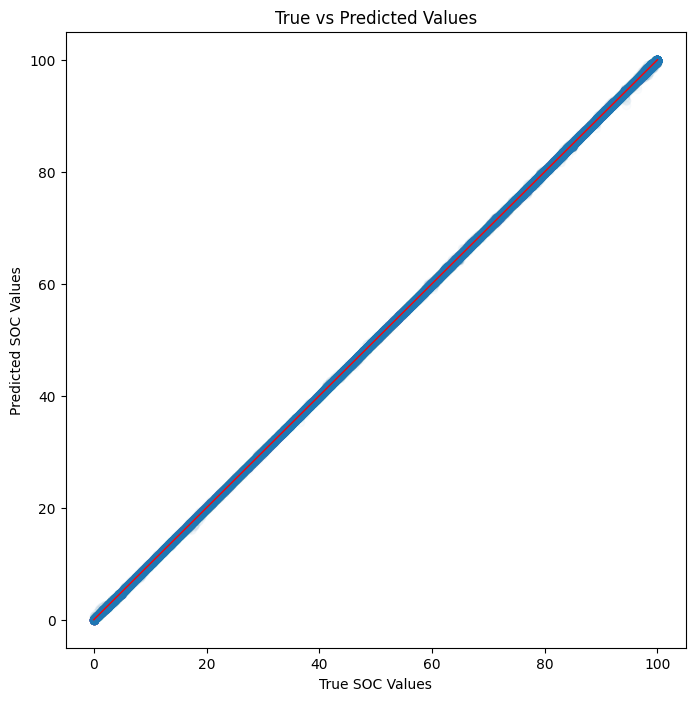

In [416]:
plt.figure(figsize=(8, 8))
plt.scatter(test_y, pred, alpha = 0.02)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='red', linewidth=1)
plt.xlabel('True SOC Values')
plt.ylabel('Predicted SOC Values')
plt.title('True vs Predicted Values')
plt.show()

In [417]:
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse))

RMSE :  0.119378


In [418]:
import joblib
joblib.dump(pipeline, 'data/soc_model_nn.pkl', compress = 1)

['data/soc_model_nn.pkl']

# Error analysis

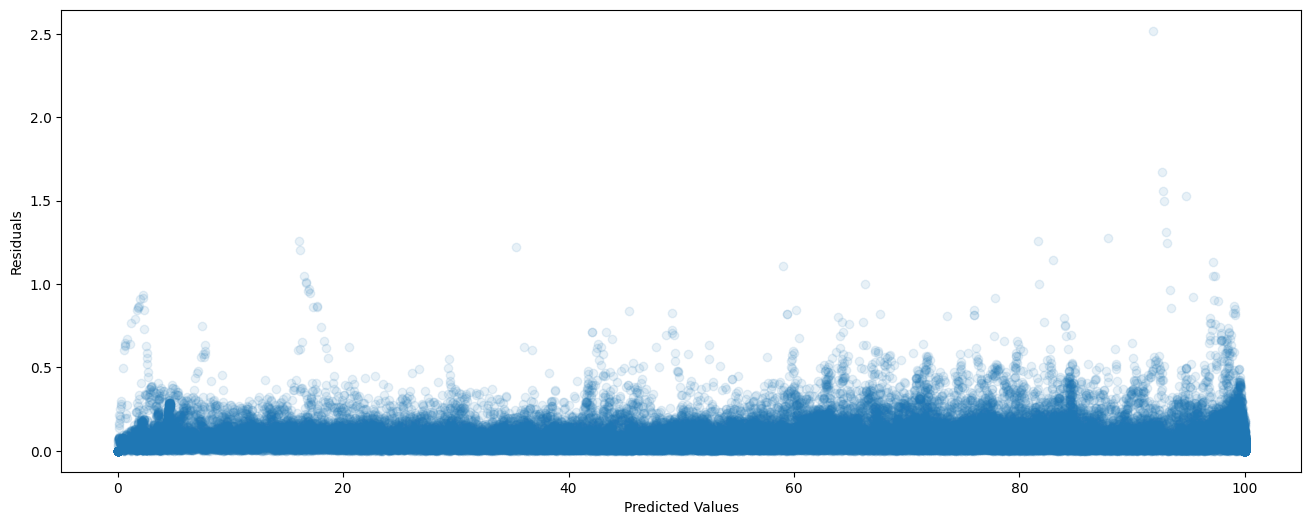

In [419]:
residuals_abs = abs(test_y - pred)
plt.figure(figsize=(16, 6))
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.scatter(pred, residuals_abs, alpha = 0.1)

In [420]:
rdf = pd.DataFrame({'test_y': test_y, 'pred': pred, 'res': residuals_abs})

<Axes: xlabel='bin', ylabel='Residuals mean'>

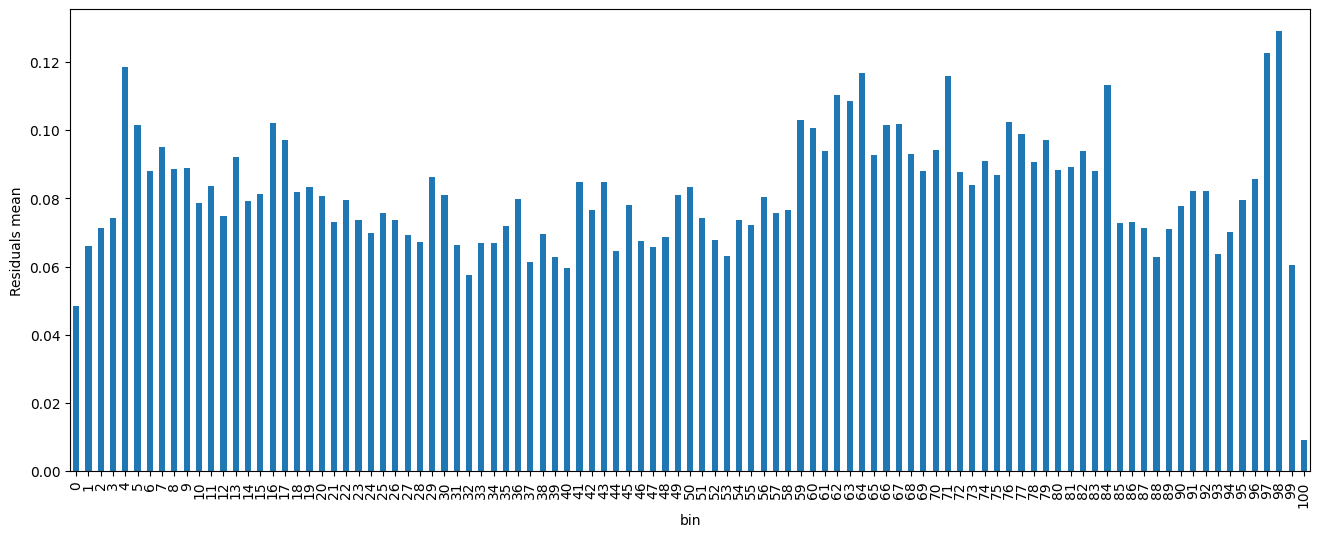

In [421]:
rdf['bin'] = (rdf.pred / 1).astype('int32')

plt.figure(figsize=(16, 6))
plt.xlabel('Predicted Values (buckets)')
plt.ylabel('Residuals mean')
(rdf.groupby('bin')['res'].mean()).plot(kind='bar')

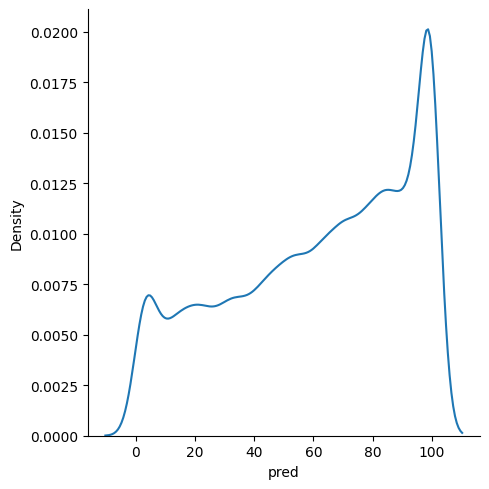

In [422]:
sns.displot(data=rdf, x="pred", kind="kde")

In [423]:
# target value deviation distribution from soc_d
div = df2.calculated_soc  - df2.soc_d
div = div.clip(-10,10)

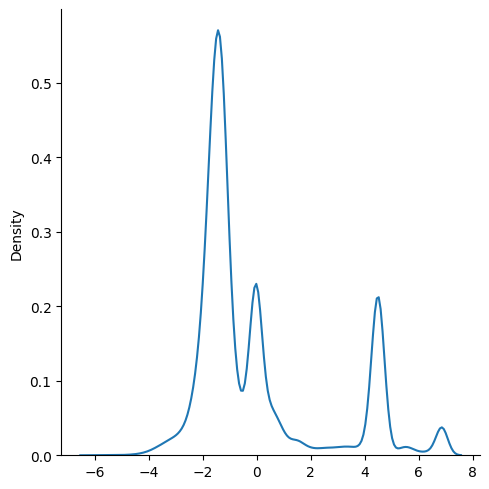

In [424]:
sns.displot(data=div, kind="kde")